<a href="https://colab.research.google.com/github/danielkennedy1/CS6524_Computer_Vision/blob/main/CelebA_Conv_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import warnings
import kagglehub
from pathlib import Path
from google.colab import drive
from datetime import datetime


warnings.filterwarnings('ignore')

In [2]:
FOLDER_NUMBER = 4 # Change to put checkpoints into different folders
SAMPLE_COUNT = 50_000

In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
warnings.filterwarnings('ignore')

Using device: cuda


In [5]:
dataset_path = kagglehub.dataset_download(
    "kushsheth/face-vae",
)

100%|██████████| 1.33G/1.33G [00:07<00:00, 191MB/s]

Extracting files...


In [6]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))][:SAMPLE_COUNT]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

In [7]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # [0, 1] -> [-1, 1]
])

In [8]:
dataset = CelebADataset(f'{dataset_path}/img_align_celeba/img_align_celeba', transform=transform)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0)

print(f"Dataset size: {len(dataset)}")
print(f"No. of Batches: {len(dataloader)}")
print(f"Sample shape: {dataset[0].shape}")

Dataset size: 50000
No. of Batches: 49
Sample shape: torch.Size([3, 256, 256])


In [9]:
def plot_image(image):
    '''
    Takes in an image and shows it using matplotlib
    this is used to visualize the data and also the outputs of our network
    '''
    image = (image + 1) / 2 # [-1, 1] -> [0, 1]
    plt.figure()
    plt.imshow(image.cpu().permute(1, 2, 0).numpy())
    plt.grid('off')
    plt.axis('off')
    plt.show()

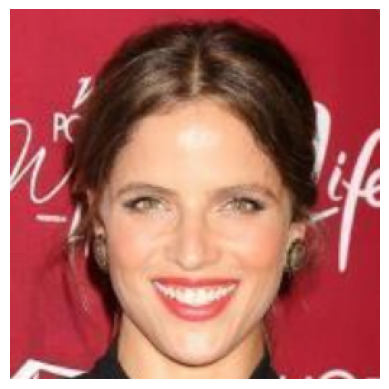

In [10]:
plot_image(dataset[0])

In [11]:
# --- Convolutional VAE ---
class ConvVAE(nn.Module):
    def __init__(self, latent_dimension: int, image_channels: int):
        super().__init__()
        self.latent_dim = latent_dimension
        self.image_channels = image_channels

        # Encoder: 3x256x256 -conv> 32x128x128 -conv> 64x64x64 -conv> 128x32x32 -conv> 256x16x16 -flatten> 65536 -fcx2> latent_dim (mu, logvar)
        self.enc = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 64x64
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 32x32
            nn.ReLU(True),
            nn.Conv2d(128, self.latent_dim, kernel_size=4, stride=2, padding=1), # 16x16
            nn.ReLU(True),
        )
        self.enc_fc_mu = nn.Linear(self.latent_dim * 16 * 16, self.latent_dim)
        self.enc_fc_logvar = nn.Linear(self.latent_dim * 16 * 16, self.latent_dim)

        # Decoder: latent_dim (z) -fc> 65536 -> 128x32x32 -> 64x64x64 -> 32x128x128 -> 3x256x256
        self.dec_fc = nn.Linear(self.latent_dim, self.latent_dim * 16 * 16)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, 128, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.ReLU(True),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1),   # 256 x 256
            nn.Tanh(),  # output in [-1,1]
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu = self.enc_fc_mu(h)
        logvar = self.enc_fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z_vec):
        h = self.dec_fc(z_vec)
        h = h.view(z_vec.size(0), self.latent_dim, 16, 16)
        x_recon = self.dec(h)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z_vec = self.reparameterize(mu, logvar)
        x_recon = self.decode(z_vec)
        return x_recon, mu, logvar

def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction="sum") / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl, recon_loss, kl

vae = ConvVAE(latent_dimension=512, image_channels=3).to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

print("VAE parameters (M):", sum(p.numel() for p in vae.parameters())/1e6)


VAE parameters (M): 203.887555


In [12]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction="sum") / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl, recon_loss, kl

In [13]:
drive.mount('/content/drive')

checkpoint_dir = Path(f'/content/drive/MyDrive/CS6524/VAE_checkpoints_{FOLDER_NUMBER}')
checkpoint_dir.mkdir(exist_ok=True, parents=True)

Mounted at /content/drive


In [14]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)

def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['loss']

In [15]:
load_checkpoint(vae, vae_opt, checkpoint_dir / 'latest.pt')

(19, tensor(5124.2549, device='cuda:0', requires_grad=True))

In [17]:
num_vae_epochs = 20

sum_loss_history = []
recon_loss_history = []
kl_loss_history = []

vae.train()
for epoch in range(num_vae_epochs):
    pbar = tqdm(dataloader, desc=f"VAE Epoch {epoch+1}/{num_vae_epochs}")

    total_sum_loss = 0.0
    total_recon_loss = 0.0
    total_kl_loss = 0.00
    total_kl_loss = 0.0

    for imgs in pbar:
        imgs = imgs.to(device)
        x_recon, mu, logvar = vae(imgs)
        loss, r_loss, kl = vae_loss(x_recon, imgs, mu, logvar)

        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()

        total_sum_loss += loss.item() * imgs.size(0)
        total_recon_loss += r_loss.item() * imgs.size(0)
        total_kl_loss += kl.item() * imgs.size(0)
        pbar.set_postfix({"loss": loss.item(), "recon": r_loss.item(), "kl": kl.item()})

    save_checkpoint(vae, vae_opt, epoch, loss, checkpoint_dir / 'latest.pt')

    sum_loss_history.append(total_sum_loss / len(dataset))
    recon_loss_history.append(total_recon_loss / len(dataset))
    kl_loss_history.append(total_kl_loss / len(dataset))

    print(f"Epoch {epoch+1}: avg loss = {total_sum_loss/len(dataset):.4f}")


VAE Epoch 1/20: 100%|██████████| 49/49 [02:20<00:00,  2.87s/it, loss=4.79e+3, recon=3.94e+3, kl=846]


Epoch 1: avg loss = 4973.2494


VAE Epoch 2/20: 100%|██████████| 49/49 [02:22<00:00,  2.92s/it, loss=5.14e+3, recon=4.29e+3, kl=847]


Epoch 2: avg loss = 4769.3633


VAE Epoch 3/20: 100%|██████████| 49/49 [02:19<00:00,  2.84s/it, loss=4.6e+3, recon=3.73e+3, kl=864]


Epoch 3: avg loss = 4668.6100


VAE Epoch 4/20: 100%|██████████| 49/49 [02:26<00:00,  2.98s/it, loss=4.45e+3, recon=3.61e+3, kl=838]


Epoch 4: avg loss = 4602.2678


VAE Epoch 5/20: 100%|██████████| 49/49 [02:19<00:00,  2.84s/it, loss=4.69e+3, recon=3.84e+3, kl=852]


Epoch 5: avg loss = 4444.9397


VAE Epoch 6/20: 100%|██████████| 49/49 [02:22<00:00,  2.90s/it, loss=4.1e+3, recon=3.24e+3, kl=863]


Epoch 6: avg loss = 4362.0713


VAE Epoch 7/20: 100%|██████████| 49/49 [02:22<00:00,  2.91s/it, loss=4.2e+3, recon=3.33e+3, kl=875]


Epoch 7: avg loss = 4279.5629


VAE Epoch 8/20: 100%|██████████| 49/49 [02:19<00:00,  2.86s/it, loss=4.29e+3, recon=3.43e+3, kl=858]


Epoch 8: avg loss = 4220.4340


VAE Epoch 9/20: 100%|██████████| 49/49 [02:22<00:00,  2.90s/it, loss=4.01e+3, recon=3.14e+3, kl=877]


Epoch 9: avg loss = 4111.4649


VAE Epoch 10/20: 100%|██████████| 49/49 [02:20<00:00,  2.87s/it, loss=4.07e+3, recon=3.22e+3, kl=857]


Epoch 10: avg loss = 4225.3955


VAE Epoch 11/20: 100%|██████████| 49/49 [02:21<00:00,  2.88s/it, loss=3.87e+3, recon=3.01e+3, kl=865]


Epoch 11: avg loss = 4004.9658


VAE Epoch 12/20: 100%|██████████| 49/49 [02:25<00:00,  2.97s/it, loss=4.03e+3, recon=3.16e+3, kl=870]


Epoch 12: avg loss = 3921.1382


VAE Epoch 13/20: 100%|██████████| 49/49 [02:23<00:00,  2.92s/it, loss=3.76e+3, recon=2.91e+3, kl=855]


Epoch 13: avg loss = 3972.3424


VAE Epoch 14/20: 100%|██████████| 49/49 [02:21<00:00,  2.88s/it, loss=4.16e+3, recon=3.27e+3, kl=890]


Epoch 14: avg loss = 3893.0882


VAE Epoch 15/20: 100%|██████████| 49/49 [02:23<00:00,  2.94s/it, loss=3.81e+3, recon=2.96e+3, kl=851]


Epoch 15: avg loss = 3820.6820


VAE Epoch 16/20: 100%|██████████| 49/49 [02:21<00:00,  2.88s/it, loss=3.67e+3, recon=2.82e+3, kl=852]


Epoch 16: avg loss = 3755.1766


VAE Epoch 17/20: 100%|██████████| 49/49 [02:19<00:00,  2.84s/it, loss=3.69e+3, recon=2.82e+3, kl=871]


Epoch 17: avg loss = 3753.2295


VAE Epoch 18/20: 100%|██████████| 49/49 [02:20<00:00,  2.88s/it, loss=3.83e+3, recon=2.97e+3, kl=857]


Epoch 18: avg loss = 3706.9485


VAE Epoch 19/20: 100%|██████████| 49/49 [02:23<00:00,  2.92s/it, loss=3.64e+3, recon=2.77e+3, kl=868]


Epoch 19: avg loss = 3656.0801


VAE Epoch 20/20: 100%|██████████| 49/49 [02:20<00:00,  2.87s/it, loss=3.54e+3, recon=2.68e+3, kl=868]


Epoch 20: avg loss = 3626.4807


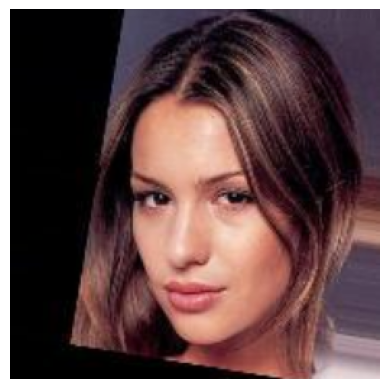

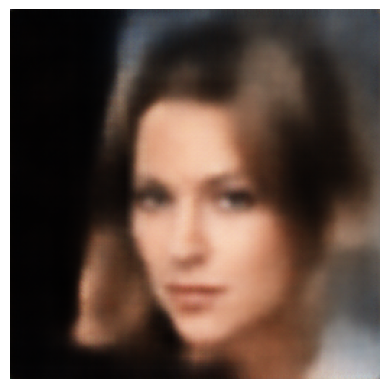

In [16]:
vae.eval()

imgs = next(iter(dataloader))
imgs = imgs.to(device)[:8]
with torch.no_grad():
    recon, _, _ = vae(imgs)

plot_image(imgs[0])
plot_image(recon[0])

In [17]:
sum_loss_history

[51306.8574575,
 22650.287561875,
 14975.63595625,
 12456.9624746875,
 10358.594685,
 9052.77334375,
 8111.46876875,
 7443.93030359375,
 7167.626401875,
 6714.99792234375,
 6214.046335,
 5992.18451828125,
 5874.0857209375,
 5527.19898890625,
 5479.1066021875,
 5524.97798640625,
 5086.41914609375,
 5047.4889490625,
 4819.7385084375,
 6047.0856028125]

In [18]:
recon_loss_history

[51009.8232775,
 22124.4248503125,
 14308.4342178125,
 11755.945471875,
 9621.7343490625,
 8296.35091421875,
 7338.1767546875,
 6654.5178603125,
 6362.647135,
 5903.9707046875,
 5400.028389375,
 5170.03904125,
 5045.98262375,
 4697.49848578125,
 4643.917724375,
 4680.63707078125,
 4247.37428375,
 4204.052560625,
 3973.360706171875,
 5188.8262590625]

In [19]:
kl_loss_history

[297.03394760391234,
 525.8626743359375,
 667.2018186914063,
 701.016974921875,
 736.8602517578125,
 756.4224347851563,
 773.2920463476562,
 789.4124489257813,
 804.9792491601562,
 811.02719015625,
 814.017900234375,
 822.1454687109375,
 828.1030680078125,
 829.7004989453125,
 835.1888822070313,
 844.3409075195312,
 839.0448800585938,
 843.436402578125,
 846.3778214453125,
 858.2593254296875]